El objetivo de esta práctica es la implementación de un clasificador tipo SVC en R. En particular, vamos a emplear el dataframe Heart,  que incluye un total de 13 variables físicas y médicas acerca de distintas personas (edad, sexo, colesterol, etc) y, como variable dependiente, presencia de enfermedad cardiaca (SI/NO):

1. age           age in years
2. sex           (1 = male; 0 = female)
3. cp            chest pain type
4. trestbps      resting blood pressure (in mm Hg on admission to the hospital)
5. chol          serum cholestoral in mg/dl
6. fbs           (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7. restecg       resting electrocardiographic results
8. thalach       maximum heart rate achieved
9. exang         exercise induced angina (1 = yes; 0 = no)
10. oldpeak      ST depression induced by exercise relative to rest
11. slope        the slope of the peak exercise ST segment
12. ca           number of major vessels (0-3) colored by flourosopy
13. thal         3 = normal; 6 = fixed defect; 7 = reversable defect
14. target       1 or 0

Suponiendo que en una ciudad disponemos de los datos médicos de buena parte de la población la práctica consiste en construir un SVM que nos permita predecir el riesgo de enfermedad de la población a partir de los datos de entrenamiento, por ejemplo para determinar si es necesario ampliar la planta de cardiología de un hospital.

Este ejercicio es relativamente sencillo, en tanto que la variable dependiente es categórica con sólo dos valores (SI/NO) y el modelo lineal de SVM funciona bien.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

# Cargar el conjunto de datos
heart = pd.read_csv("https://raw.githubusercontent.com/crisurdiales/DataMining4SmartCities/main/heart.csv")

print(heart.dtypes)

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
target        int64
dtype: object


Antes de utilizar el SVC de sklearn, necesitamos cambiar la variable thal a numérica, ya que la función no admite datos categóricos.

A continuación, dividimos el dataset en entrenamiento y test y obtenemos el clasificador. Finalmente, calculamos la salida de los datos de testeo para avaluar el modelo.

In [ ]:
# Convertir variable categórica en variable dummy utilizando One-Hot Encoding
heart = pd.get_dummies(heart, columns=['thal'])

# Dividir los datos en entrenamiento y prueba
X = heart.drop(columns=['target']) # Características
y = heart['target'] # Variable objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar el clasificador SVM con kernel lineal
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

# Predecir los datos de prueba
y_pred = classifier.predict(X_test)

Podemos evaluar la predicción usando una matriz de confusión. Recordemos que esta incluye:
*  True Positive (TP): El modelo predijo correctamente una instancia como positiva (verdadero positivo).
*  True Negative (TN): El modelo predijo correctamente una instancia como negativa (verdadero negativo).
*  False Positive (FP): El modelo predijo incorrectamente una instancia como positiva cuando en realidad era negativa (falso positivo).
*  False Negative (FN): El modelo predijo incorrectamente una instancia como negativa cuando en realidad era positiva (falso negativo).

La precisión se puede calcular como los aciertos sobre el total de datos, la sensibilidad como los TP entre el total de P y la especificidad como los TN entre el total de N.

In [ ]:
# Calcular la matriz de confusión y la precisión
cm = confusion_matrix(y_test, y_pred)

# Acceder a los valores individuales en la matriz de confusión
TP = cm[1, 1]  # True Positive
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative

# Calcular métricas de evaluación como precisión, sensibilidad y especificidad
precision = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Matriz de Confusión: (TN, FP, FN, TP)")
print(cm)
print("Precisión:", precision)
print("Sensibilidad:", sensitivity)
print("Especificidad:", specificity)

Matriz de Confusión: (TN, FP, FN, TP)
[[62  5]
 [ 7 17]]
Precisión: 0.8681318681318682
Sensibilidad: 0.7083333333333334
Especificidad: 0.9253731343283582


Se puede observar que el sistema tiene una precisión del 86.8% y que es mejor en especificidad que en sensibilidad, ésto es detecta bastante bien los casos negativos, pero pierde un 30% de los positivos.

Una forma de visualizar los resultados es usar un gráfico de dispersión. En este gráfico, podemos dibujar las predicciones del clasificador sobre el espacio de las variables independientes. En problema de esto es que, por resticciones de visualización en el plano, sólo podemos representar las variables dos a dos. Por ejemplo, el ejemplo siguiente muestra las variables 0 y 1, que en nuestro dataset son edad y sexo, pero podríamos cambiar positives.iloc[:, 0], positives.iloc[:, 1] y negatives.iloc[:, 0], negatives.iloc[:, 1] a los valores que deseemos para representar otro par de variables.

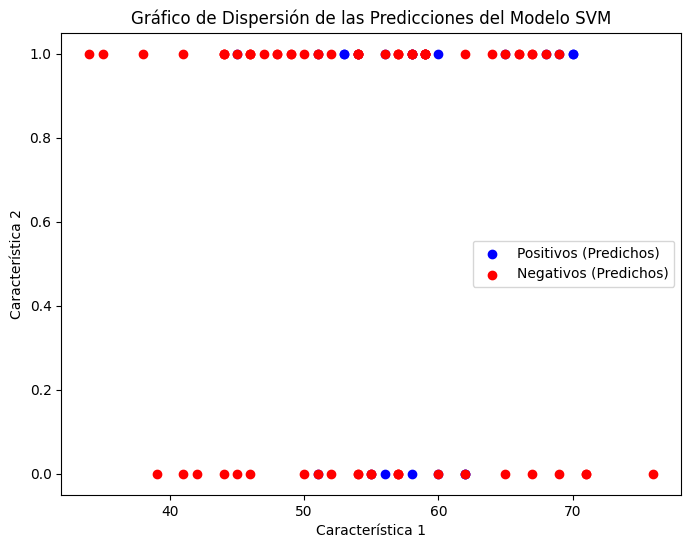

In [ ]:
import matplotlib.pyplot as plt

# Obtener los índices de los datos predichos como positivos y negativos
positives = X_test[y_pred == 1]
negatives = X_test[y_pred == 0]

# Graficar los datos
plt.figure(figsize=(8, 6))
plt.scatter(positives.iloc[:, 0], positives.iloc[:, 1], color='blue', label='Positivos (Predichos)')
plt.scatter(negatives.iloc[:, 0], negatives.iloc[:, 1], color='red', label='Negativos (Predichos)')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.title('Gráfico de Dispersión de las Predicciones del Modelo SVM')
plt.legend()
plt.show()


Visualizar la separación cuando el hiperplano tiene tantas dimensiones es complejo, por lo que vamos a usar PCA para reducir el numero de variables independientes y poder apreciar mejor la misma.

Comenzaremos calculando el número de componentes necesario empleando un scree-plot.

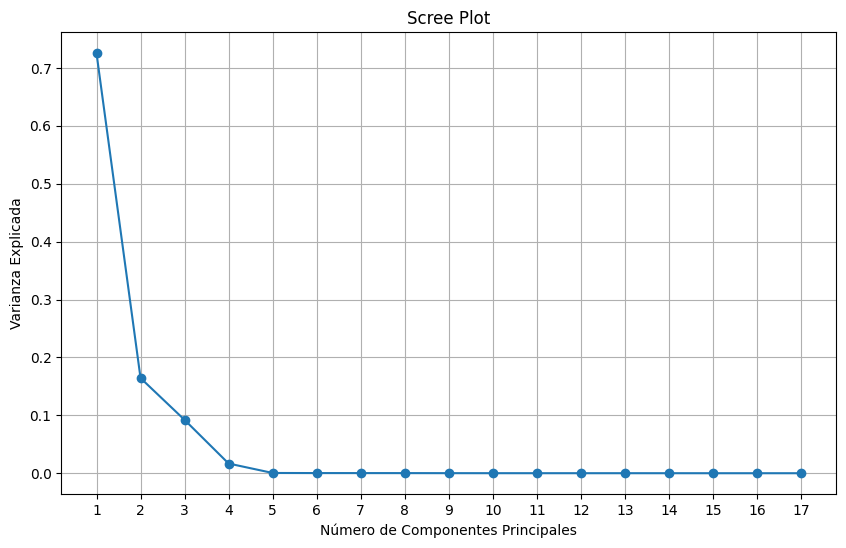

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Aplicar PCA para reducir la dimensionalidad
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

# Calcular la varianza explicada para cada componente principal
varianza_explicada = pca.explained_variance_ratio_

# Calcular el número de componentes a retener utilizando el scree plot
num_componentes = len(varianza_explicada)
componentes = np.arange(num_componentes) + 1

# Graficar el scree plot
plt.figure(figsize=(10, 6))
plt.plot(componentes, varianza_explicada, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.xticks(componentes)
plt.grid(True)
plt.show()

# Determinar el número de componentes a retener basado en el scree plot
# (Por ejemplo, podrías elegir los componentes que explican una cierta cantidad de varianza, como el 95%)


Ahora, tomando el codo en 4 componentes, volvemos a ajustar el modelo SVC usando sólo esos 4 valores.

In [ ]:
# Proyectamos nuestros datos de testeo y test con 4 componentes PCA
pca = PCA(n_components=4)

X_train_pca_selected = pca.fit_transform(X_train)
X_test_pca_selected = pca.transform(X_test)

# Entrenar el clasificador SVM con kernel lineal y solo las primeras 4 componentes principales
classifierPCA = SVC(kernel='linear')
classifierPCA.fit(X_train_pca_selected, y_train)

# Predecir los datos de prueba
y_pred_pca = classifierPCA.predict(X_test_pca_selected)


A continuación podemos evaluar el modelo igual que anteriormente

In [ ]:
# Calcular la matriz de confusión
cmPCA = confusion_matrix(y_test, y_pred_pca)

# Calcular métricas de evaluación como precisión, sensibilidad y especificidad
precisionPCA = accuracy_score(y_test, y_pred_pca)
sensitivityPCA = cmPCA[1, 1] / (cmPCA[1, 1] + cmPCA[1, 0])
specificityPCA = cmPCA[0, 0] / (cmPCA[0, 0] + cmPCA[0, 1])

print("Matriz de Confusión: (TN, FP, FN, TP)")
print(cmPCA)
print("Precisión:", precisionPCA)
print("Sensibilidad:", sensitivityPCA)
print("Especificidad:", specificityPCA)

Matriz de Confusión: (TN, FP, FN, TP)
[[61  6]
 [18  6]]
Precisión: 0.7362637362637363
Sensibilidad: 0.25
Especificidad: 0.9104477611940298


In [2]:
import seaborn as sns

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Tamaño de la fuente
heatmap = sns.heatmap(cmPCA, annot=True, fmt='d', cmap='Blues', cbar=False)

# Añadir etiquetas de los ejes
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión')

# Mostrar el heatmap
plt.show()


NameError: name 'cmPCA' is not defined

<Figure size 800x600 with 0 Axes>

Si observamos la precisión del modelo, vemos que disminuye con respecto a usar todas las variables de un 86% a un 73%. En concreto, el modelo falla mucho más a la hora de detectar TP y FN, esto es, varios positivos se pierden al predecir (se baja del 70 al 25% de sensibilidad). Este resultado no es aceptable de cara a la predicción, pero lo vamos a usar simplemente para ilustrar gráficamente la separación que impone el hiperplano.

En la gráfica de dispersión ahora podemos representar dos a dos las 4 componentes que tenemos en los ejes X e Y. Al haber un número de componentes mucho menor que el de variables, los efectos de la separación resultan mucho más visibles, principalmente en las dos componentes más importantes. Puede probarse a incrementar los valores de componentes que usamos para los ejes y se verá como se pierde visualmente la separación.

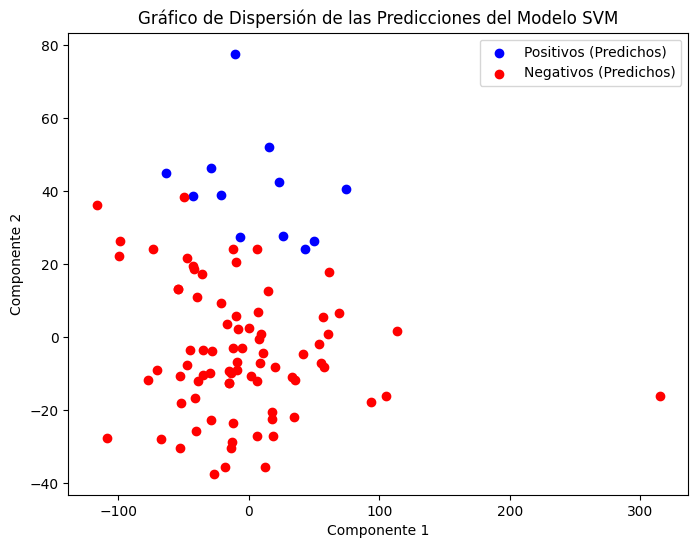

In [ ]:
# Convertir las primeras 4 componentes de X_test_pca_selected a un DataFrame
X_test_pca_df = pd.DataFrame(X_test_pca_selected, columns=['Componente 1', 'Componente 2', 'Componente 3', 'Componente 4'])

# Obtener los índices de los datos predichos como positivos y negativos
positivesPCA = X_test_pca_df[y_pred_pca == 1]
negativesPCA = X_test_pca_df[y_pred_pca == 0]

# Graficar los datos
plt.figure(figsize=(8, 6))
plt.scatter(positivesPCA.iloc[:, 0], positivesPCA.iloc[:, 1], color='blue', label='Positivos (Predichos)')
plt.scatter(negativesPCA.iloc[:, 0], negativesPCA.iloc[:, 1], color='red', label='Negativos (Predichos)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('Gráfico de Dispersión de las Predicciones del Modelo SVM')
plt.legend()
plt.show()
